**Heart Disease UCI**

-Kalp hastalığına sahip olma oranın da çeşitli etkenlerin nasıl sonuç verdiğini anlamaya çalıştım.

-Hedef değişken **'num'** sütunudur, bu sütun kişinin kalp hastalığına sahip olup olmadığını belirtir (0: hastalık yok, 1: hastalık var).

-Bu tahminin pratikteki önemi, kalp hastalığı riskini etkileyen faktörleri belirleyerek önleyici tedbirler alınmasına ve hastalığın erken teşhis edilmesine yardımcı olmaktır.






In [95]:
# Data set yükleme
!pip install ucimlrepo
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xgboost lightgbm catboost
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
# Makine öğrenmesi için
!pip install catboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
# Uyarı gizleme
import warnings
warnings.filterwarnings("ignore")

# Veri setini yükleme
from ucimlrepo import fetch_ucirepo

# Dataset'i getirme
heart_disease = fetch_ucirepo(id=45)

# Data
X = heart_disease.data.features
y = heart_disease.data.targets

# Hedefi ikiliye dönüştürme (0: hastalık yok, 1: hastalık)
y['num'] = y['num'].apply(lambda x: 1 if x > 0 else 0)

# metadata
print(heart_disease.metadata)

# Variable information
print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

🔎 df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB
None
 df.describe()
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.69306

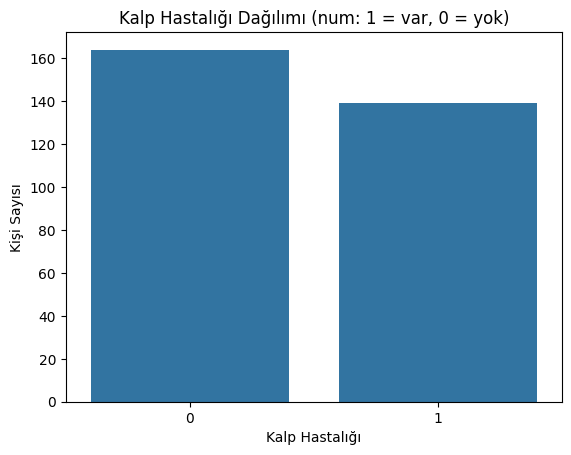

In [42]:
#Veri tipi ve genel istatistikler
print("🔎 df.info()")
print(X.info())
print(" df.describe()")
print(X.describe())
print(" df.head()")
print(X.head())

#Eksik veri kontrolü
print("\n❓ Eksik veri sayısı")
print(X.isnull().sum())

#Hedef değişkenin dağılımı
sns.countplot(x=y['num'])
plt.title("Kalp Hastalığı Dağılımı (num: 1 = var, 0 = yok)")
plt.xlabel("Kalp Hastalığı")
plt.ylabel("Kişi Sayısı")
plt.show()


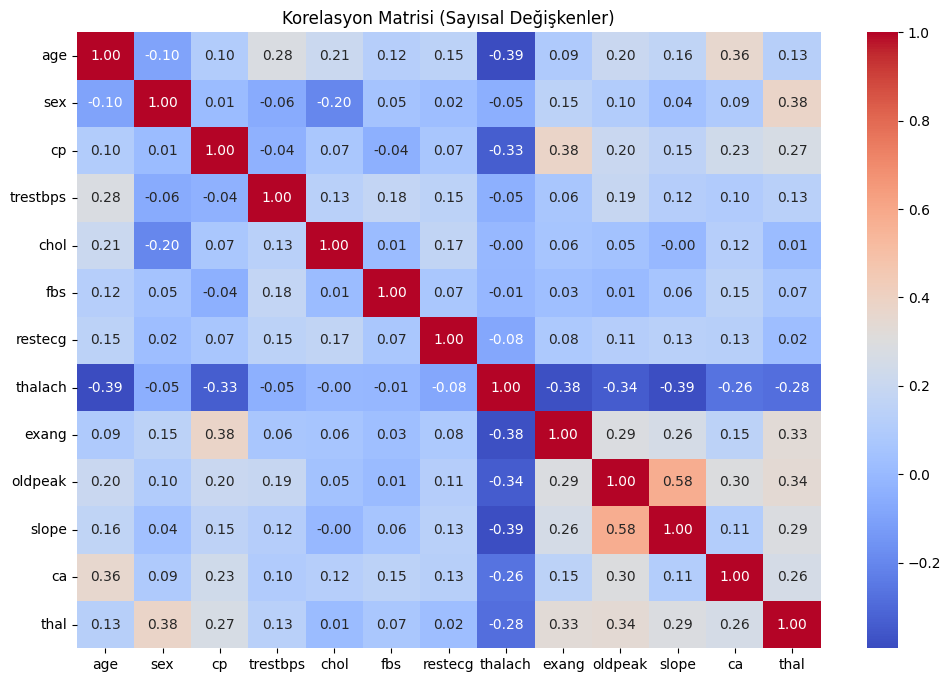

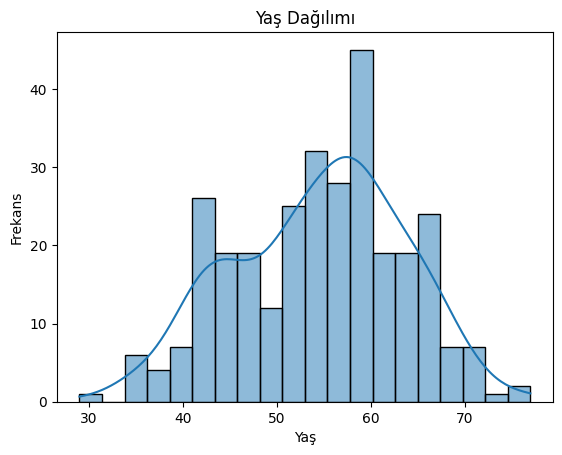

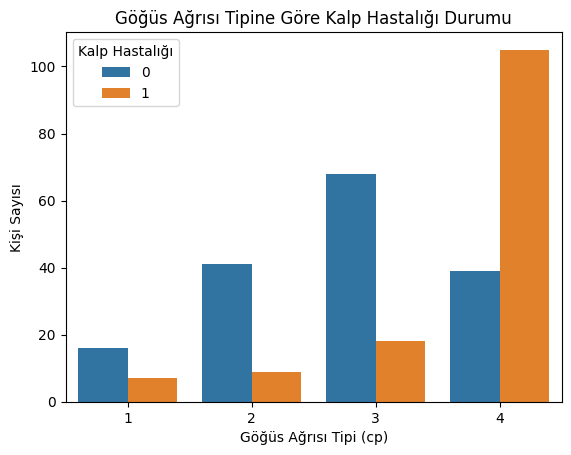

In [43]:
#Korelasyon Matrisi
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(X[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasyon Matrisi (Sayısal Değişkenler)")
plt.show()

#Yaş dağılımı
sns.histplot(X["age"], bins=20, kde=True)
plt.title("Yaş Dağılımı")
plt.xlabel("Yaş")
plt.ylabel("Frekans")
plt.show()

#Göğüs Ağrısı Tipi (cp) ve Kalp Hastalığı Etkileşimi
sns.countplot(data=pd.concat([X, y], axis=1), x="cp", hue="num")
plt.title("Göğüs Ağrısı Tipine Göre Kalp Hastalığı Durumu")
plt.xlabel("Göğüs Ağrısı Tipi (cp)")
plt.ylabel("Kişi Sayısı")
plt.legend(title="Kalp Hastalığı")
plt.show()


In [44]:
#Kategorik ve sayısal sütunları ayırma
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
categorical_cols += [col for col in X.columns if X[col].nunique() < 10 and X[col].dtype != 'float64']
categorical_cols = list(set(categorical_cols))

numerical_cols = [col for col in X.columns if col not in categorical_cols]

print("🔠 Kategorik sütunlar:", categorical_cols)
print("🔢 Sayısal sütunlar:", numerical_cols)


🔠 Kategorik sütunlar: ['cp', 'sex', 'restecg', 'exang', 'slope', 'fbs']
🔢 Sayısal sütunlar: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal']


In [45]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# OneHotEncoding kategorik veriler için, StandardScaler sayısallar için, Imputer eksik değerler için

def create_preprocessor(categorical_cols, numerical_cols, scaler_type='Standard'):
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ])
    if scaler_type == 'Standard':
        numerical_transformer.steps.append(('scaler', StandardScaler()))
    elif scaler_type == 'MinMax':
        numerical_transformer.steps.append(('scaler', MinMaxScaler()))
    else:
        raise ValueError("scaler_type 'Standard' veya 'MinMax' olmalıdır.")


    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])


    preprocessor = ColumnTransformer(transformers=[
        ("onehot", categorical_transformer, categorical_cols),
        ("scaler", numerical_transformer, numerical_cols)
    ])
    return preprocessor

# StandardScaler ile ön işleme
preprocessor_standard = create_preprocessor(categorical_cols, numerical_cols, scaler_type='Standard')

# MinMaxScaler ile ön işleme
preprocessor_minmax = create_preprocessor(categorical_cols, numerical_cols, scaler_type='MinMax')

# Eğitim / Test bölünmesi
X_train, X_test, y_train, y_test = train_test_split(X, y["num"], test_size=0.2, random_state=42)

# StandardScaler ile Fit-transform eğitim verisine, transform test verisine
X_train_standard = preprocessor_standard.fit_transform(X_train)
X_test_standard = preprocessor_standard.transform(X_test)

# MinMaxScaler ile Fit-transform eğitim verisine, transform test verisine
X_train_minmax = preprocessor_minmax.fit_transform(X_train)
X_test_minmax = preprocessor_minmax.transform(X_test)

# StandardScaler ile dönüştürülmüş verileri görmek için:
print("Ön işleme tamamlandı.")
print("StandardScaler ile dönüştürülmüş eğitim verisi boyutu:", X_train_standard.shape)
print("StandardScaler ile dönüştürülmüş test verisi boyutu:", X_test_standard.shape)

# MinMaxScaler ile dönüştürülmüş verileri görmek için:
print("MinMaxScaler ile dönüştürülmüş eğitim verisi boyutu:", X_train_minmax.shape)
print("MinMaxScaler ile dönüştürülmüş test verisi boyutu:", X_test_minmax.shape)

Ön işleme tamamlandı.
StandardScaler ile dönüştürülmüş eğitim verisi boyutu: (242, 23)
StandardScaler ile dönüştürülmüş test verisi boyutu: (61, 23)
MinMaxScaler ile dönüştürülmüş eğitim verisi boyutu: (242, 23)
MinMaxScaler ile dönüştürülmüş test verisi boyutu: (61, 23)


🔍 Model Değerlendirmesi (StandardScaler ile)

Classification Report (StandardScaler):
              precision    recall  f1-score   support

           0       0.88      0.79      0.84        29
           1       0.83      0.91      0.87        32

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



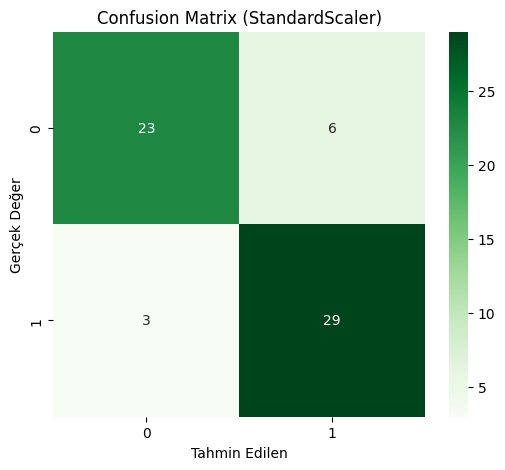

ROC AUC (StandardScaler): 0.9127


🔍 Model Değerlendirmesi (MinMaxScaler ile)

Classification Report (MinMaxScaler):
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        29
           1       0.85      0.88      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



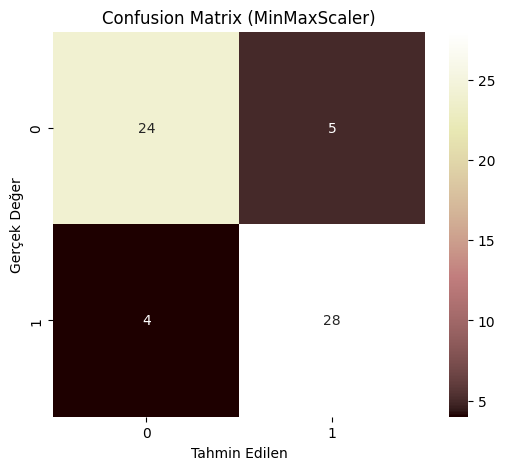

ROC AUC (MinMaxScaler): 0.9332

Karşılaştırma Özeti
StandardScaler ile ROC AUC Skoru: 0.9127
MinMaxScaler ile ROC AUC Skoru:   0.9332


In [83]:
# StandardScaler ile Model Değerlendirmesi
print("="*30)
print("🔍 Model Değerlendirmesi (StandardScaler ile)")
print("="*30)

model_standard = LogisticRegression(random_state=42)
model_standard.fit(X_train_standard, y_train)

# Tahminleri StandardScaler ile işlenmiş test verisi üzerinden
y_pred_standard = model_standard.predict(X_test_standard)
y_proba_standard = model_standard.predict_proba(X_test_standard)[:, 1]

# Sonuçları göster
print("\nClassification Report (StandardScaler):")
print(classification_report(y_test, y_pred_standard))

# Confusion Matrix
conf_matrix_standard = confusion_matrix(y_test, y_pred_standard)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_standard, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix (StandardScaler)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.show()

# ROC-AUC Skoru
roc_auc_standard = roc_auc_score(y_test, y_proba_standard)
print(f"ROC AUC (StandardScaler): {roc_auc_standard:.4f}\n\n")


# MinMaxScaler ile Model Değerlendirmesi
print("="*30)
print("🔍 Model Değerlendirmesi (MinMaxScaler ile)")
print("="*30)

# Yeni bir model oluştur
model_minmax = LogisticRegression(random_state=42)
model_minmax.fit(X_train_minmax, y_train)

# Tahminleri MinMaxScaler ile işlenmiş test verisi üzerinden
y_pred_minmax = model_minmax.predict(X_test_minmax)
y_proba_minmax = model_minmax.predict_proba(X_test_minmax)[:, 1]

# Sonuçları göster
print("\nClassification Report (MinMaxScaler):")
print(classification_report(y_test, y_pred_minmax))

# Confusion Matrix
conf_matrix_minmax = confusion_matrix(y_test, y_pred_minmax)
plt.figure(figsize=(6, 5))

sns.heatmap(conf_matrix_minmax, annot=True, fmt="d", cmap="pink")
plt.title("Confusion Matrix (MinMaxScaler)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.show()

# ROC-AUC Skoru
roc_auc_minmax = roc_auc_score(y_test, y_proba_minmax)
print(f"ROC AUC (MinMaxScaler): {roc_auc_minmax:.4f}\n")

# --- SONUÇ ÖZETİ ---
print("="*30)
print("Karşılaştırma Özeti")
print("="*30)
print(f"StandardScaler ile ROC AUC Skoru: {roc_auc_standard:.4f}")
print(f"MinMaxScaler ile ROC AUC Skoru:   {roc_auc_minmax:.4f}")


--- Random Forest Eğitimi Başlıyor ---
Random Forest - Accuracy:  0.8852
Random Forest - Precision: 0.9032
Random Forest - Recall:    0.8750
Random Forest - F1-score:  0.8889


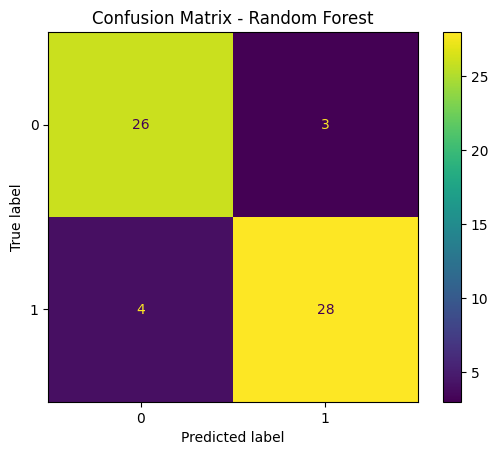


--- Logistic Regression Eğitimi Başlıyor ---
Logistic Regression - Accuracy:  0.8852
Logistic Regression - Precision: 0.8788
Logistic Regression - Recall:    0.9062
Logistic Regression - F1-score:  0.8923


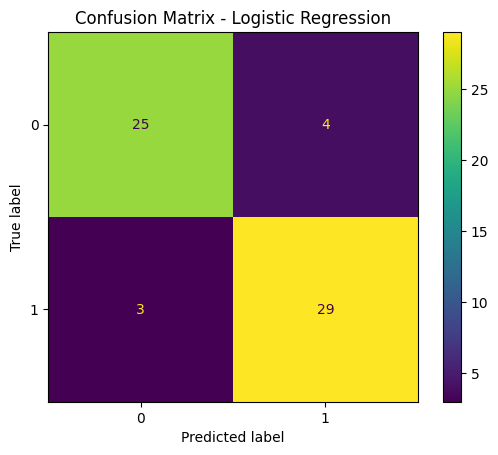


--- SVM Eğitimi Başlıyor ---
SVM - Accuracy:  0.9016
SVM - Precision: 0.9333
SVM - Recall:    0.8750
SVM - F1-score:  0.9032


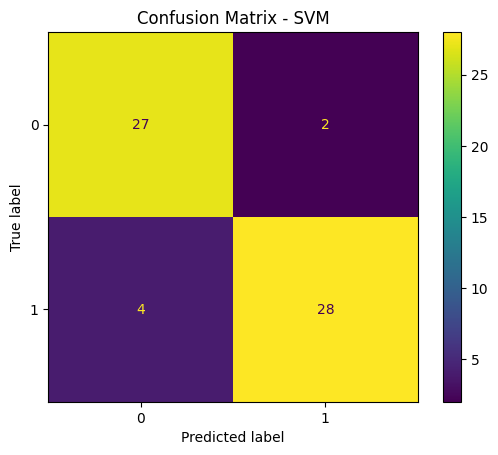


--- k-NN Eğitimi Başlıyor ---
k-NN - Accuracy:  0.9180
k-NN - Precision: 0.9355
k-NN - Recall:    0.9062
k-NN - F1-score:  0.9206


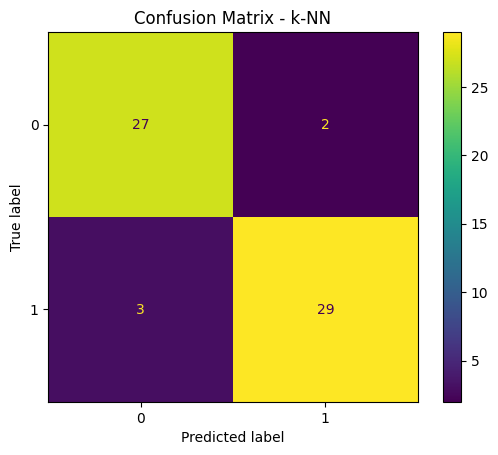


--- XGBoost Eğitimi Başlıyor ---
XGBoost - Accuracy:  0.8361
XGBoost - Precision: 0.8667
XGBoost - Recall:    0.8125
XGBoost - F1-score:  0.8387


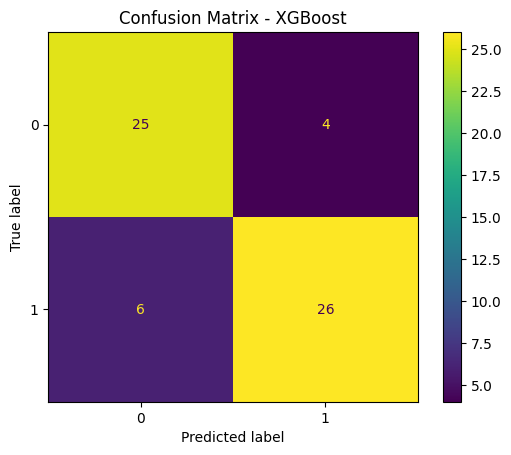


--- LightGBM Eğitimi Başlıyor ---
[LightGBM] [Info] Number of positive: 107, number of negative: 135
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442149 -> initscore=-0.232446
[LightGBM] [Info] Start training from score -0.232446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

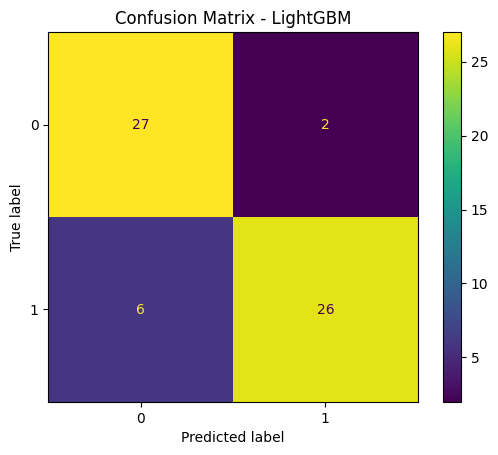


--- CatBoost Eğitimi Başlıyor ---
CatBoost - Accuracy:  0.8689
CatBoost - Precision: 0.9000
CatBoost - Recall:    0.8438
CatBoost - F1-score:  0.8710


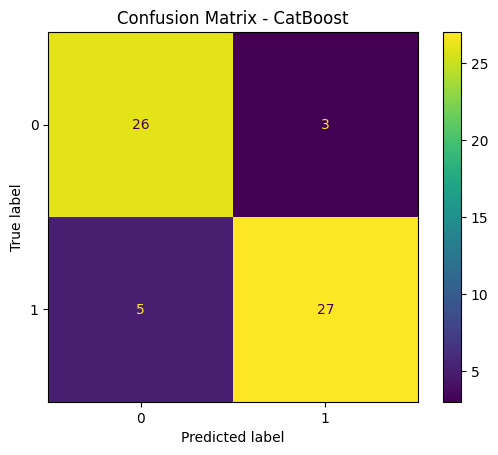


Tüm Modellerin Değerlendirme Metrikleri:
                     Accuracy  Precision   Recall  F1-score
Random Forest        0.885246   0.903226  0.87500  0.888889
Logistic Regression  0.885246   0.878788  0.90625  0.892308
SVM                  0.901639   0.933333  0.87500  0.903226
k-NN                 0.918033   0.935484  0.90625  0.920635
XGBoost              0.836066   0.866667  0.81250  0.838710
LightGBM             0.868852   0.928571  0.81250  0.866667
CatBoost             0.868852   0.900000  0.84375  0.870968


In [84]:
from sklearn.preprocessing import StandardScaler

# Modelleri tanımla
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(random_state=42))
    ]),
    "SVM": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ("scaler", StandardScaler()),
        ("svc", SVC(probability=True, random_state=42))
    ]),
    "k-NN": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier())
    ]),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Performans metriklerini tutmak için bir dictionary oluştur
metrics_results = {}

# Tüm modeller için eğitim, tahmin, metrik hesaplama ve confusion matrix
for name, model in models.items():
    print(f"\n--- {name} Eğitimi Başlıyor ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrikleri hesapla
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    metrics_results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

    # Metrik sonuçlarını yazdır
    print(f"{name} - Accuracy:  {acc:.4f}")
    print(f"{name} - Precision: {prec:.4f}")
    print(f"{name} - Recall:    {rec:.4f}")
    print(f"{name} - F1-score:  {f1:.4f}")

    # Confusion matrix görselleştirme
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Tüm modellerin metrik sonuçlarını bir DataFrame'de göster
results_df = pd.DataFrame(metrics_results).T
print("\nTüm Modellerin Değerlendirme Metrikleri:")
print(results_df)

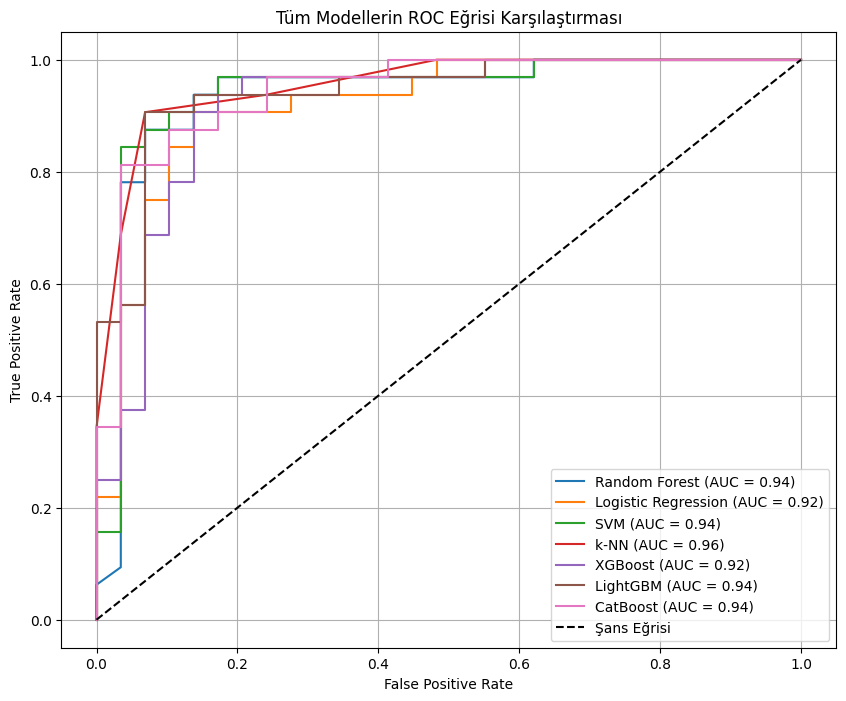

In [89]:
# ROC-AUC eğrisi

from sklearn.impute import SimpleImputer

# ROC eğrisi tüm modeller için çizilir
plt.figure(figsize=(10, 8))

# Modeller için ROC eğrisi hesapla ve çiz
for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            continue
        # ROC-AUC ve ROC eğrisi
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)

        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
#Sonuçları çıkarma ve tabloyu düzenleme
plt.plot([0, 1], [0, 1], "k--", label="Şans Eğrisi")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Tüm Modellerin ROC Eğrisi Karşılaştırması")
plt.legend()
plt.grid(True)
plt.show()


In [91]:
#Model Performans Değerlendirmesi
metrics_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)
best_model_name = metrics_df_sorted.index[0]
best_model_metrics = metrics_df_sorted.iloc[0]

print(f"\n--- Model Performans Değerlendirmesi ---")
print(f"En İyi Performansı Veren Model: {best_model_name}")
print(f"Bu Modelin Metrikleri:")
print(best_model_metrics)

# Metrikler üzerinde en iyi performansı belirleme
print(f"\n--- Metrik Bazında Karşılaştırma ---")
for metric in results_df.columns:
  best_on_metric = results_df[metric].idxmax()
  best_value_on_metric = results_df[metric].max()
  print(f"'{metric}' metriğinde en iyi model: {best_on_metric} ({best_value_on_metric:.4f})")




--- Model Performans Değerlendirmesi ---
En İyi Performansı Veren Model: k-NN
Bu Modelin Metrikleri:
Accuracy     0.918033
Precision    0.935484
Recall       0.906250
F1-score     0.920635
Name: k-NN, dtype: float64

--- Metrik Bazında Karşılaştırma ---
'Accuracy' metriğinde en iyi model: k-NN (0.9180)
'Precision' metriğinde en iyi model: k-NN (0.9355)
'Recall' metriğinde en iyi model: Logistic Regression (0.9062)
'F1-score' metriğinde en iyi model: k-NN (0.9206)



🔎 K-NN MODELİ AŞIRI ÖĞRENME (OVERFITTING) ANALİZİ
En İyi Parametreler: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 13, 'classifier__weights': 'uniform'}

Ortalama Çapraz Doğrulama Skoru (Eğitim Seti): 0.8307
Test Seti Skoru: 0.8689
Eğitim ve Test Skorları Arasındaki Fark: -0.0382
En İyi k-NN Parametreleri: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 13, 'classifier__weights': 'uniform'}
En İyi k-NN Cross-Validation (Accuracy) Skoru: 0.8307

⚙️ Ayarlanmış k-NN Model Sonuçları:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        29
           1       0.93      0.81      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



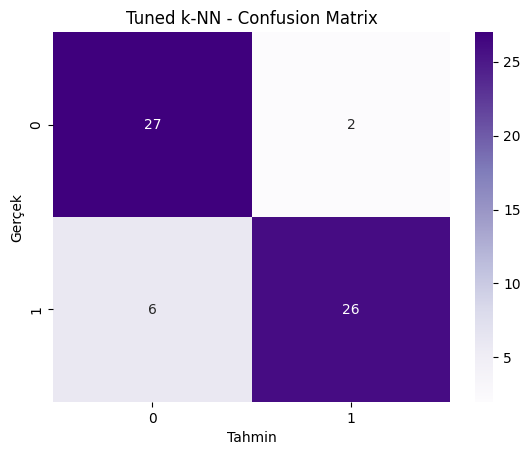

Test Seti ROC AUC (Tuned k-NN): 0.9370

--- Yorumlama ---
Durum: İyi Dengelenmiş Model.
Eğitim ve test skorları birbirine yakın. Modelin genelleme yeteneği iyi görünüyor.

Manuel Eğitim Seti Skoru (Tüm eğitim verisi üzerinde): 0.8471


In [92]:
#Ön işlemciyi ve modeli içeren tam bir Pipeline oluştur
knn_pipeline_full = Pipeline([
    ('preprocessor', preprocessor_standard),
    ('classifier', KNeighborsClassifier())
])

# k-NN için parametre grid'i tanımla
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# GridSearchCV'yi çalıştırma
grid_search_knn = GridSearchCV(knn_pipeline_full, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# AŞIRI ÖĞRENME ANALİZİ

print("\n" + "="*40)
print("🔎 K-NN MODELİ AŞIRI ÖĞRENME (OVERFITTING) ANALİZİ")
print("="*40)

# En iyi modeli ve parametreleri alma
best_knn_model = grid_search_knn.best_estimator_
print(f"En İyi Parametreler: {grid_search_knn.best_params_}")

# Çapraz doğrulama skorunu alma
train_cv_score = grid_search_knn.best_score_
print(f"\nOrtalama Çapraz Doğrulama Skoru (Eğitim Seti): {train_cv_score:.4f}")

# Test seti skorunu hesaplama
test_score = best_knn_model.score(X_test, y_test)
print(f"Test Seti Skoru: {test_score:.4f}")

#İki skoru karşılaştır ve yorumla
difference = train_cv_score - test_score
print(f"Eğitim ve Test Skorları Arasındaki Fark: {difference:.4f}")

print(f"En İyi k-NN Parametreleri: {grid_search_knn.best_params_}")
print(f"En İyi k-NN Cross-Validation (Accuracy) Skoru: {grid_search_knn.best_score_:.4f}")

# En iyi k-NN modeli üzerinde tahmin yap
best_kNN_model = grid_search_knn.best_estimator_
y_pred_kNN_tuned = best_knn_model.predict(X_test)
y_proba_kNN_tuned = best_knn_model.predict_proba(X_test)[:, 1]

print("\n⚙️ Ayarlanmış k-NN Model Sonuçları:")
print(classification_report(y_test, y_pred_kNN_tuned))
conf_matrix_kNN_tuned = confusion_matrix(y_test, y_pred_kNN_tuned)
sns.heatmap(conf_matrix_kNN_tuned, annot=True, fmt="d", cmap="Purples")
plt.title("Tuned k-NN - Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()

roc_auc_kNN_tuned = roc_auc_score(y_test, y_proba_kNN_tuned)
print(f"Test Seti ROC AUC (Tuned k-NN): {roc_auc_kNN_tuned:.4f}")

print("\n--- Yorumlama ---")
if difference > 0.05 and train_cv_score > 0.8:
    print("DİKKAT: Aşırı Öğrenme (Overfitting) riski olabilir.")
    print("Model, eğitim verisini ezberlemiş ve yeni veride genelleme yapmakta zorlanıyor olabilir.")
    print("Çözüm olarak: Modelin karmaşıklığını azaltmayı (örn: k değerini artırmak) veya daha fazla veri toplamayı düşünebilirsiniz.")
elif train_cv_score < 0.75:
    print("DİKKAT: Yetersiz Öğrenme (Underfitting) olabilir.")
    print("Model, hem eğitim hem de test verisinde düşük performans gösteriyor. Verideki deseni öğrenmek için yeterince karmaşık değil.")
    print("Çözüm olarak: Daha karmaşık bir model deneyebilir veya modele yeni öznitelikler ekleyebilirsiniz.")
else:
    print("Durum: İyi Dengelenmiş Model.")
    print("Eğitim ve test skorları birbirine yakın. Modelin genelleme yeteneği iyi görünüyor.")

# Manuel Eğitim Seti Skorunu Görmek
manual_train_score = best_knn_model.score(X_train, y_train)
print(f"\nManuel Eğitim Seti Skoru (Tüm eğitim verisi üzerinde): {manual_train_score:.4f}")

**Modelin Pratik Kullanımı**

-Güvenilir ve Kullanıma Hazır: Modelin test performansı, eğitim performansından bile iyi. Bu, modelin yeni verilere çok iyi genelleme yaptığını gösterir.

-Aşırı Öğrenme (Overfitting) Yok: Eğitim ve test skorları arasındaki fark negatif, bu da modelin ezber yapmadığını, aksine öğrendiğini kanıtlıyor.

-Yüksek Başarı: %87 genel doğruluk ve %93.7 ROC AUC skoru ile model, sınıfları birbirinden ayırmada mükemmel bir iş çıkarıyor.

-Dengeli Performans: Precision ve Recall metrikleri dengeli. Model, pozitif tahminlerinde oldukça güvenilir (Precision: 0.93).

**Daha İyi Sonuçlar İçin Öneriler**

-Öznitelik Mühendisliği: Mevcut verilerden yeni ve daha anlamlı sütunlar oluşturmak.

-Farklı Ön İşleme: StandardScaler yerine RobustScaler gibi farklı ölçekleyiciler denemek.

-Ensemble Yöntemleri: VotingClassifier veya StackingClassifier ile birden fazla modelin gücünü birleştirmek.

**Veri Setiyle İlgili Gözlemler**

-İyi Ayrışmış Veri: Sınıflar (0 ve 1) arasında net bir ayrım var, bu da k-NN gibi bir modelin neden bu kadar başarılı olduğunu açıklıyor.

-Etkili Ön İşleme: Kullandığınız preprocessor (eksik değer doldurma, kategorik dönüşüm, ölçeklendirme) çok başarılı çalışmış.

-Yeterli Veri Miktarı: Veri seti, modelin anlamlı desenler öğrenmesi için yeterli büyüklükte görünüyor.


--- SVM için GridSearchCV Başlıyor ---
En İyi SVM Parametreleri: {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
En İyi SVM Cross-Validation (ROC AUC) Skoru: 0.8958

⚙️ Ayarlanmış (Tuned) SVM Model Sonuçları:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



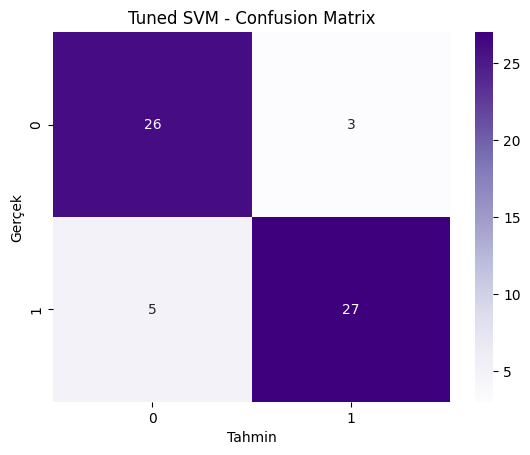

Test Seti ROC AUC (Tuned SVM): 0.9267

--- Random Forest için GridSearchCV Başlıyor ---
En İyi Random Forest Parametreleri: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}
En İyi Random Forest Cross-Validation (ROC AUC) Skoru: 0.9010

🌳 Ayarlanmış (Tuned) Random Forest Model Sonuçları:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



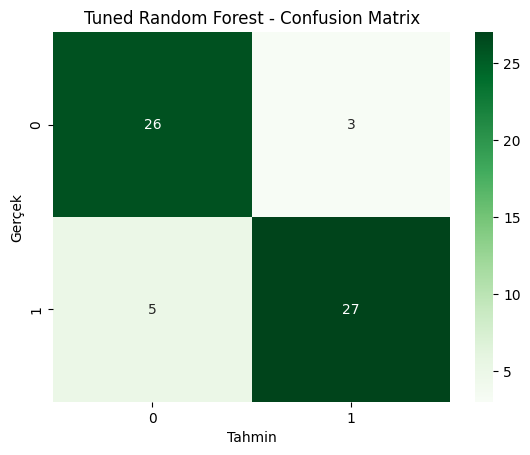

Test Seti ROC AUC (Tuned Random Forest): 0.9353


In [93]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
# SVM için GridSearchCV

print("\n--- SVM için GridSearchCV Başlıyor ---")

#Ön işlemciyi ve modeli içeren bir Pipeline oluşturma
svm_pipeline_full = Pipeline([
    ('preprocessor', preprocessor_standard),
    ('classifier', SVC(probability=True, random_state=42))
])

#Parametre grid'ini Pipeline'daki adım isimleriyle güncelleme
param_grid_svm = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01],
    'classifier__kernel': ['rbf']
}

# GridSearchCV'yi bu tam Pipeline üzerinde çalıştırma
grid_search_svm = GridSearchCV(svm_pipeline_full, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print(f"En İyi SVM Parametreleri: {grid_search_svm.best_params_}")
print(f"En İyi SVM Cross-Validation (ROC AUC) Skoru: {grid_search_svm.best_score_:.4f}")

# En iyi SVM modeli üzerinde tahmin yapma (best_estimator_ artık tam bir pipeline)
best_svm_model = grid_search_svm.best_estimator_
y_pred_svm_tuned = best_svm_model.predict(X_test)
y_proba_svm_tuned = best_svm_model.predict_proba(X_test)[:, 1]

print("\n⚙️ Ayarlanmış (Tuned) SVM Model Sonuçları:")
print(classification_report(y_test, y_pred_svm_tuned))
conf_matrix_svm_tuned = confusion_matrix(y_test, y_pred_svm_tuned)
sns.heatmap(conf_matrix_svm_tuned, annot=True, fmt="d", cmap="Purples")
plt.title("Tuned SVM - Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()
roc_auc_svm_tuned = roc_auc_score(y_test, y_proba_svm_tuned)
print(f"Test Seti ROC AUC (Tuned SVM): {roc_auc_svm_tuned:.4f}")


# Random Forest için GridSearchCV

print("\n--- Random Forest için GridSearchCV Başlıyor ---")

#Pipeline oluştur
rf_pipeline_full = Pipeline([
    ('preprocessor', preprocessor_standard),
    ('classifier', RandomForestClassifier(random_state=42))
])

#Parametre grid'ini güncelle
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

#GridSearchCV'yi çalıştır
grid_search_rf = GridSearchCV(rf_pipeline_full, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print(f"En İyi Random Forest Parametreleri: {grid_search_rf.best_params_}")
print(f"En İyi Random Forest Cross-Validation (ROC AUC) Skoru: {grid_search_rf.best_score_:.4f}")

# En iyi RF modeli üzerinde tahmin yap
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)
y_proba_rf_tuned = best_rf_model.predict_proba(X_test)[:, 1]

print("\n🌳 Ayarlanmış (Tuned) Random Forest Model Sonuçları:")
print(classification_report(y_test, y_pred_rf_tuned))
conf_matrix_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
sns.heatmap(conf_matrix_rf_tuned, annot=True, fmt="d", cmap="Greens")
plt.title("Tuned Random Forest - Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()
roc_auc_rf_tuned = roc_auc_score(y_test, y_proba_rf_tuned)
print(f"Test Seti ROC AUC (Tuned Random Forest): {roc_auc_rf_tuned:.4f}")

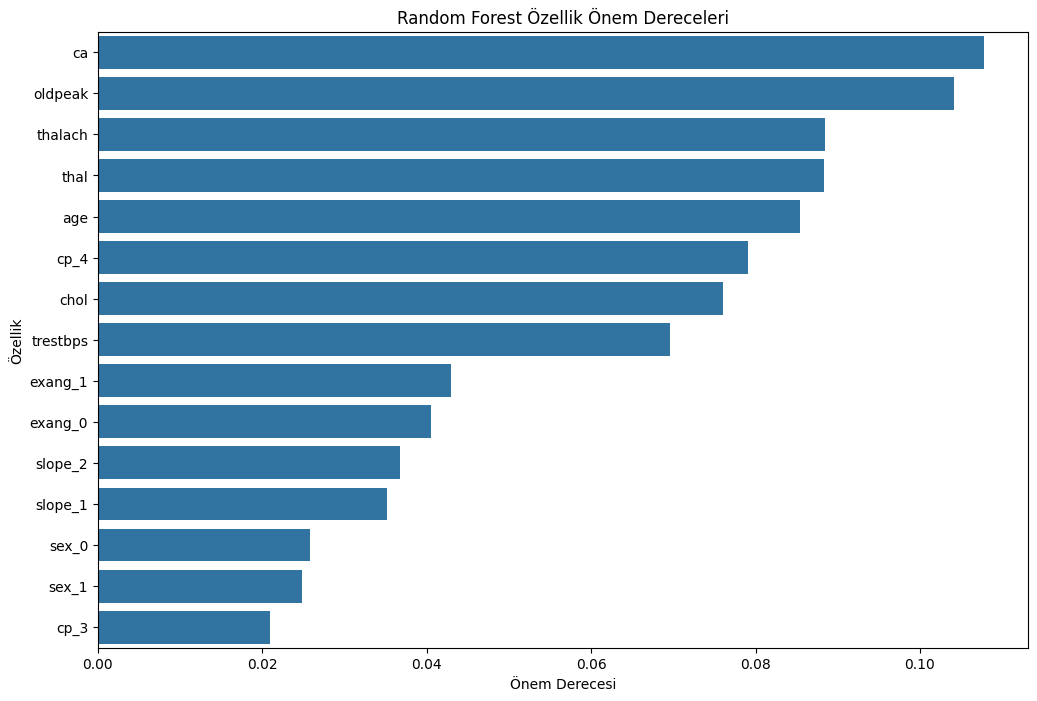

In [94]:
# Feature Importance görselleştirmesi

# Tuned Random Forest modelinin özellik önem derecelerini al
feature_importances = best_rf_model.named_steps['classifier'].feature_importances_

# Kategorik sütunların OneHotEncoder sonrası isimlerini al
onehot_transformer = preprocessor.named_transformers_['onehot'].named_steps['onehot']
try:
    onehot_feature_names = list(onehot_transformer.get_feature_names_out(categorical_cols))
except AttributeError:
    onehot_feature_names = list(onehot_transformer.get_feature_names(categorical_cols))


# Sayısal sütun isimlerini ekle
all_feature_names = onehot_feature_names + numerical_cols

# Özellik önem derecelerini bir DataFrame'e koy (isimlerle eşleştirerek)
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

# Önem derecelerine göre sırala
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Görselleştirme
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15)) # En önemli 15 özelliği göster
plt.title('Random Forest Özellik Önem Dereceleri')
plt.xlabel('Önem Derecesi')
plt.ylabel('Özellik')
plt.show()